The following code helps you visualize the submarine data and contains the crucial information about the data such as size of measurement domain, number of grid points and frequency modes etc. 

Our first task is to import the data into python (similarly MATLAB). Three files are available, "subdata.npy" is a numpy binary file most conveninet for Python users. "subtata.mat" is best if you plan to use MATLAB and "subdata.csv" is the same data in text format if you are having trouble with the other formats. In MATLAB you can simply use the load command. In Python, and in particular if you are using something like Colab you need some utilities to load the data. Here's a small snippet for loading data from your Google drive.   

In [ ]:
from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

data_path = '/content/drive/My Drive/AMATH 582/HW 1/subdata.npy'

d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)
print(d.shape)


(262144, 49)


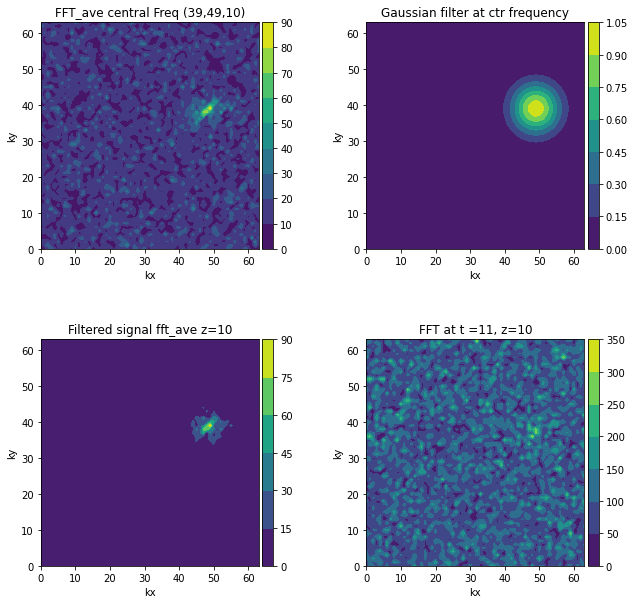

In [ ]:
# import libraries for plotting isosurfaces
import plotly
import plotly.graph_objs as go
# utility for clearing output of cell as loop runs in notebook
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Gaussian Filter
def gaussian_filter(x,y,z,s):
    fun_val = np.exp( - ( ( (x - K_grid[freqsig_idx[0]])**2 + (y - K_grid[freqsig_idx[1]])**2
                            + (z-K_grid[freqsig_idx[2]])**2) / (2*s**2)  )) 
    return fun_val
# IC initialization 

L = 10; # length of spatial domain (cube of side L = 2*10)
N_grid = 64; # number of grid points/Fourier modes in each direction
xx = np.linspace(-L, L, N_grid+1) #spatial grid in x dir
x = xx[0:N_grid]
y = x # same grid in y,z direction
z = x
sig = 1.5

K_grid = (2*np.pi/(2*L))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid) # frequency grid for one coordinate

xv, yv, zv = np.meshgrid( x, y, z) # generate 3D meshgrid for plotting
kx,ky,kz = np.meshgrid(K_grid,K_grid,K_grid)
# 2D meshgrid for plotting the ave_fft
kxx, kyy = np.meshgrid( np.linspace(0,63,64),np.linspace(0,63,64))
# plot iso surfaces for every third measurement
sig_fft=np.zeros((64,64,64))
denoise_data = np.zeros((64,64,64,49))
for j in range(0,49):

  signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid))
  sig_fft =sig_fft+np.fft.fftshift(np.fft.fftn(signal))

sig_fft_ave = np.abs(sig_fft/49)
#To find the second frequency
freqsig_idx2 = np.unravel_index(np.real(sig_fft).argmax(), sig_fft.shape) 
#print(freqsig_idx2);
freqsig_pos = np.where(sig_fft_ave==np.amax(sig_fft_ave))
# location of frequency signature based on indices of the array
freqsig_idx = np.unravel_index(sig_fft_ave.argmax(), sig_fft_ave.shape) 
# Shifting the values by deleting and adding the values in the array because 
# the value in first element is should be indices of x not y, the same with 
# second element
freqsig_idx = np.insert(freqsig_idx,2,freqsig_idx[0])
freqsig_idx = np.delete(freqsig_idx,0) 

# Gaussian Filter 
g_vals = gaussian_filter(kx,ky,kz,sig)

# Applying gaussian filter 
t_ran = 11
random_datapoint = np.fft.fftshift(np.fft.fftn( np.reshape(d[:, t_ran], (N_grid, N_grid, N_grid)) ))
sig_filter = g_vals*random_datapoint 

#print(freqsig_idx)
#print(freqsig_pos)
#print(sig_fft_ave[freqsig_idx[1],freqsig_idx[0],freqsig_idx[2]])
#print(np.max(sig_fft_ave))
#print( np.fft.fftfreq( 64,(2*np.pi/(2*L)) ) );

# Variable definition
sig_fft_filter=np.zeros((64,64,64))

# Applying filter at each time step
for j in range(0,49):
  signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid))
  fft_signal= np.fft.fftshift(np.fft.fftn(signal))
  filtered_sig_fft = g_vals*fft_signal
  sig_fft_filter=  filtered_sig_fft +sig_fft_filter
  filtered_sig = np.real(np.fft.ifftn(np.fft.ifftshift(filtered_sig_fft)))
  denoise_data[:,:,:,j] = filtered_sig

# Finding each x,y,z coord from filtered signal
filtered_sig_abs = np.abs(denoise_data)
xpos = np.array([])
ypos = np.array([])
zpos = np.array([])
for j in range(0,49):
  filtered_signal_cube = filtered_sig_abs[:,:,:,j]
  position_vec_idx= np.unravel_index(filtered_signal_cube.argmax(), filtered_signal_cube.shape,order='C') 
  xpos= np.append(xpos,x[position_vec_idx[0]])
  ypos= np.append(ypos,y[position_vec_idx[1]])
  zpos= np.append(zpos,z[position_vec_idx[2]])

sig_fft_filter_avg = abs(sig_fft_filter/49)
## Plotting 
cont_levels = np.arange(0,85,5) # levels for contourf
cont_levels2 = np.arange(0,1.05,0.05) # levels for contourf
cont_levels3 = np.arange(0,100,0.05) # levels for contourf
fig, ax = plt.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

im1=ax[0][0].contourf(kxx, kyy, sig_fft_ave[:,:,10],8)
ax[0][0].set_xlabel('kx')
ax[0][0].set_ylabel('ky')
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[0][0].set_title('FFT_ave central Freq (39,49,10)')
plt.colorbar(im1, cax=cax)

im2=ax[0][1].contourf(kxx, kyy, g_vals[:,:,10],7)
ax[0][1].set_xlabel('kx')
ax[0][1].set_ylabel('ky')
divider = make_axes_locatable(ax[0][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[0][1].set_title('Gaussian filter at ctr frequency')
plt.colorbar(im2, cax=cax)

im3=ax[1][0].contourf(kxx, kyy, sig_fft_filter_avg[:,:,10],7)                      
ax[1][0].set_xlabel('kx')
ax[1][0].set_ylabel('ky')
divider = make_axes_locatable(ax[1][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[1][0].set_title('Filtered signal fft_ave z=10' )
plt.colorbar(im3, cax=cax)

zlevel=15
im4=ax[1][1].contourf(kxx, kyy, np.abs(random_datapoint[:,:,10]),7)
ax[1][1].set_xlabel('kx')
ax[1][1].set_ylabel('ky')
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[1][1].set_title('FFT at t =' +str(t_ran)+', z=10' )
plt.colorbar(im4, cax=cax)

plt.show()

#print(xpos)

#ax2.view_init(10,120)
#print(np.column_stack((xpos[0],ypos[0],zpos[0]))) 

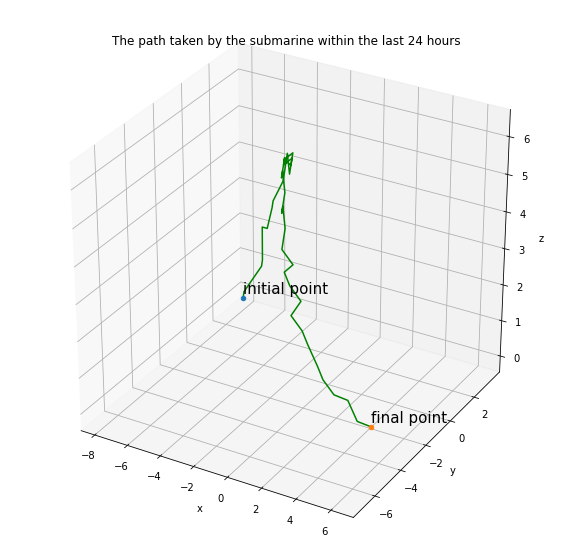

In [ ]:
fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(projection='3d')
ax2.plot3D(xpos, ypos, zpos, 'g-')
ax2.scatter(xpos[0],ypos[0],zpos[0],'ro')
ax2.text(xpos[0],ypos[0],zpos[0]+0.1,'initial point',size=15)
ax2.scatter(xpos[48],ypos[48],zpos[48],'ro')
ax2.text(xpos[48],ypos[48],zpos[48]+0.1,'final point',size=15)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('The path taken by the submarine within the last 24 hours')
plt.show()

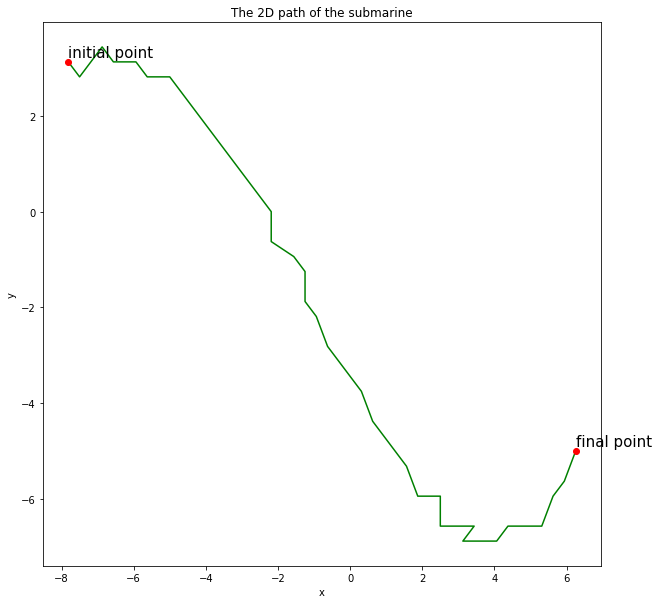

In [ ]:
fig3 = plt.figure(figsize=(10,10))
ax3 = fig3.add_subplot()
ax3.plot(xpos,ypos, 'g-')
ax3.plot(xpos[0],ypos[0],'ro')
ax3.text(xpos[0],ypos[0]+0.1,'initial point',size=15)
ax3.plot(xpos[48],ypos[48],'ro')
ax3.text(xpos[48],ypos[48]+0.1,'final point',size=15)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('The 2D path of the submarine')
plt.show()

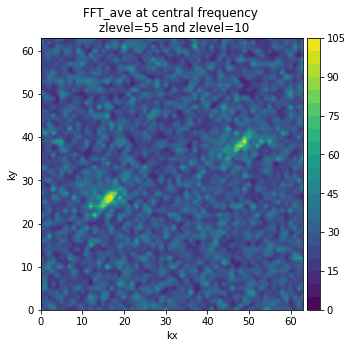

In [ ]:
cont_levels = np.arange(0,110,5) # levels for contourf
cont_levels2 = np.arange(0,1.05,0.05) # levels for contourf
cont_levels3 = np.arange(0,100,0.05) # levels for contourf
fig5, ax5 = plt.subplots(figsize=(5,5))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
im6=ax5.contourf(kxx, kyy, sig_fft_ave[:,:,55]+sig_fft_ave[:,:,10],cont_levels)
#im6=ax5.contourf(kxx, kyy, np.dstack(sig_fft_ave),cont_levels)
ax5.set_xlabel('kx')
ax5.set_ylabel('ky')
divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax5.set_title('FFT_ave at central frequency \n zlevel=55 and zlevel=10')
plt.colorbar(im6, cax=cax)

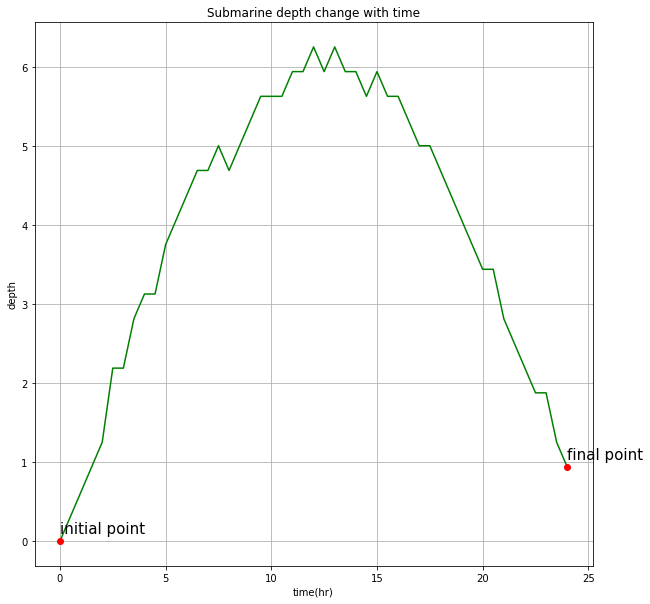

In [29]:
fig7 = plt.figure(figsize=(10,10))
ax7 = fig7.add_subplot()
ax7.plot(np.linspace(0,24,49),zpos, 'g-')
ax7.plot(0,zpos[0],'ro')
ax7.text(0,zpos[0]+0.1,'initial point',size=15)
ax7.plot(24,zpos[48],'ro')
ax7.text(24,zpos[48]+0.1,'final point',size=15)
ax7.set_xlabel('time(hr)')
ax7.set_ylabel('depth')
ax7.set_title('Submarine depth change with time')
ax7.grid()
plt.show()